In [79]:
import math

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LinearLocator

from tabulate import tabulate

# Bron : https://www.knmi.nl/nederland-nu/klimatologie/uurgegevens

In [80]:
knmi = pd.read_csv('KNMI weerdata.csv')

#knmi.head()
print(knmi.columns)

Index(['# STN', 'YYYYMMDD', '   HH', '   DD', '   FH', '   FF', '   FX',
       '    T', ' T10N', '   TD', '   SQ', '    Q', '   DR', '   RH', '    P',
       '   VV', '    N', '    U', '   WW', '   IX', '    M', '    R', '    S',
       '    O', '    Y'],
      dtype='object')


C:\Users\Ruben\AppData\Local\Temp\ipykernel_17224\316772531.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  knmi = pd.read_csv('KNMI weerdata.csv')


In [81]:
countYears = 10
daysMonth = [31, 29.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
months = ['Jan', 'Feb', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Aug', 'Sept', 'Okt', 'Nov', 'Dec']
monthlyYield0 = [28, 49.3, 96.6, 160.5, 197, 209.3, 192, 177.2, 123.9, 73.2, 34.3, 21]                  # bron nen
monthlyYield30Z = [50.5, 69.1, 122.5, 189.5, 211.1, 211.2, 196.1, 197.9, 154, 102.4, 54.8, 38.3]        # bron nen NTA8800
monthlyYield30Z = np.divide(monthlyYield30Z, monthlyYield0)

In [82]:
knmi['YYYYMMDD'] = pd.to_datetime(knmi['YYYYMMDD'], format='%Y%m%d') # format moet overeen komen met excelsheet

# Verander eenheden : J/cm2/hr --> W/m2 = *10/3.6
knmi['Q w/m2'] = knmi['    Q'] * 10 / 3.6                       # miem kolomtitel

In [89]:
# genereer data avg sunshine als functie van dag
def sunshineDaily(knmi):
    hours = list(range(1, 25))
    sunshineDay = np.array([0]*24)

    for x in range(0, len(knmi)):
        sunshineDay[x%24]+= knmi['Q w/m2'][x]

    sunshineDay = np.divide(sunshineDay, len(knmi)/24)
    return sunshineDay, hours

# genereer data als functie maand
def sunshineMonthly(knmi):
    sunshineMonth = []
    for x in range(1, 13):
        sunshineMonth.append(np.sum(knmi['Q w/m2'].where(knmi['YYYYMMDD'].dt.month == x)))
    sunshineMonth = np.divide(sunshineMonth, countYears*24)
    sunshineMonth = np.divide(sunshineMonth, daysMonth)               # Eenheden : w / m2 gemiddeld
    return sunshineMonth

# genereer data voor surf(x,y,z)
def sunshineMonthlyDaily(knmi):
    z = np.zeros((24, 12))
    for x in range(1, 13):
        for y in range(1, 25):
            temp=knmi['Q w/m2'].where((knmi['YYYYMMDD'].dt.month == x) & (knmi['   HH'] == y))
            z[y-1, x-1]+=np.sum(temp) / (daysMonth[x-1]*countYears)
    return z

# gemiddelde zon per maand ---> correctiefactor orientatie + rendement --> opgewekt vermogen per maand --> geld per maand
def monthlyYield(sunshineMonth, orientationM=monthlyYield30Z, K=0.215, A=1000, price=0.05, yearsActive=20, degradation=0.005):
    fpf=0.8
    csh=1
    
    energies = np.multiply(sunshineMonth, orientationM) # W/m2 --> W/m2 aangepast voor zonnepaneelorientatie
    
    energies = np.multiply(energies, daysMonth)     
    energies = np.multiply(energies, 24/1000)      # W/m2 --> kWh/mnd / m2
    
    energies = np.multiply(energies, fpf*csh*K*A)   # kWh/mnd/m2 ---> kWh/mnd, aangepast op rendement
    energies0=energies
    
    for x in range(1, yearsActive):
        energies = np.append(energies, np.multiply(energies0, 1-degradation*x))    # genereert opbrengsten volgende jaren rekening houdend met degradatie
    
    money = np.multiply(energies, price)                                # kWh/mnd --> euro/mnd
    return money, energies


# eerste site : ong. 100eu / 2m2 --> 100 * 1000 / 2 = 50 000 = 5e4
# hypotheekrente: 6% 
def roiSolar(money, capex=6e4, opex=0, interest=0.06):
    interest = 1 + interest / 12                    # monthly interest
    roi=[]
    prevroi=-capex
    
    for x in money:
        if prevroi < 0:
            prevroi = prevroi*interest - opex + x
        else:
            prevroi = prevroi - opex + x
        roi.append(prevroi)
    return roi


Text(0, 0.5, 'Radiatie (W/m2)')

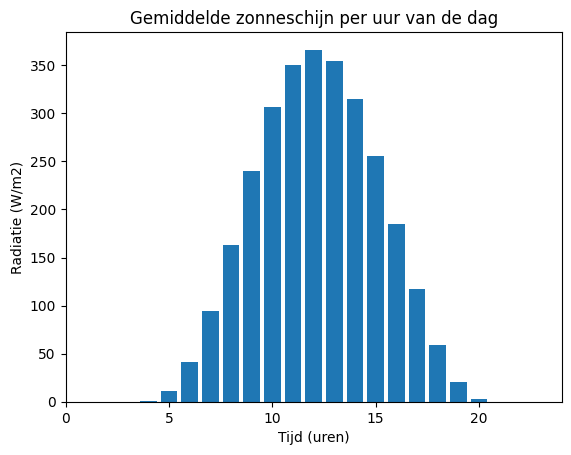

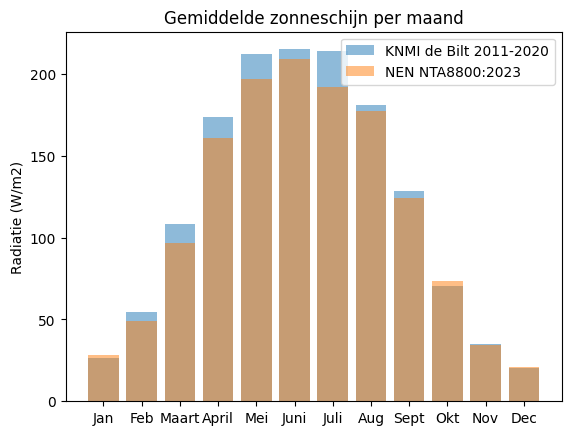

In [84]:
sunshineDay, hours = sunshineDaily(knmi)
sunshineMonth = sunshineMonthly(knmi)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

ax1.bar(hours, sunshineDay)

ax1.set_title('Gemiddelde zonneschijn per uur van de dag');
ax1.set_ylabel('Radiatie (W/m2)')
ax1.set_xlabel('Tijd (uren)')
ax1.set_xlim(0, 24);

ax2.bar(months, sunshineMonth, alpha=0.5)
ax2.bar(months, monthlyYield0, alpha=0.5)
ax2.legend(['KNMI de Bilt 2011-2020', 'NEN NTA8800:2023'])

ax2.set_title('Gemiddelde zonneschijn per maand');
ax2.set_ylabel('Radiatie (W/m2)')

In [85]:
# Bereid data voor surf plot voor
x=list(range(1,13))
y=list(range(1,25))
x, y = np.meshgrid(x, y)

z = sunshineMonthlyDaily(knmi)

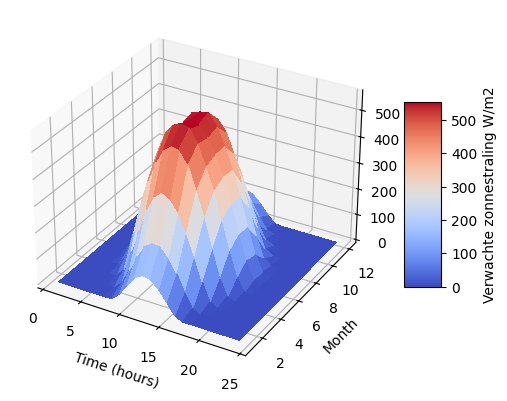

In [86]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(y, x, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Month')

fig.colorbar(surf, shrink=0.5, aspect=5, label='Verwachte zonnestraling W/m2');

In [90]:
## NEN formules:
# E el maand pv = E sol maand in * P piek pv * performance factor * schaduwfactor * praktijkfactor
# Eel           = Esol             Ppv         fpf                  csh             fpr 
# E sol = Isol * t sol * F schaduw
# Watt-piek : gedefinieerd als W/kW (/m2), ---> 215 Wp  = 21.5% rendement
# P piek pv = (P piek / paneel) * panelen of P piek / m^2 (= K) * paneeloppervlak
# Nadeel --> alleen data per maand

#
# E el maand pv = Isol * P piek pv *            performance factor * schaduwfactor * praktijkfactor
#                 KNMI   NEN 165/ commercie 215 NEN 0.8              =1              

#fpf = 0.8                       # omvormer, temp, vervuilingslosses
#fpr = np.linspace(1, 0.9, 20)   # 20 jaar 0.5% det. p.j. lineair
#csh = 1                         # 


#K = 165                         # C-si norm 2018+ N.B. eerste commerciele zoekresultaat google geeft K = 215
#A = 1000                        # m2
#price = 0.1                     # euro / kWh

#Ppv = K*A

money, energies = monthlyYield(sunshineMonth)
roi = roiSolar(money)
months = range(1, len(money)+1)

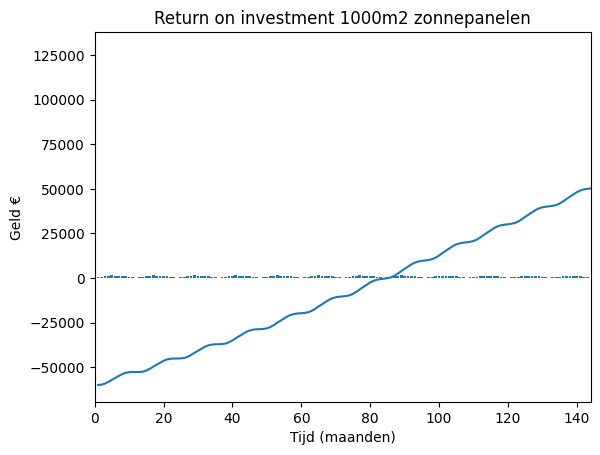

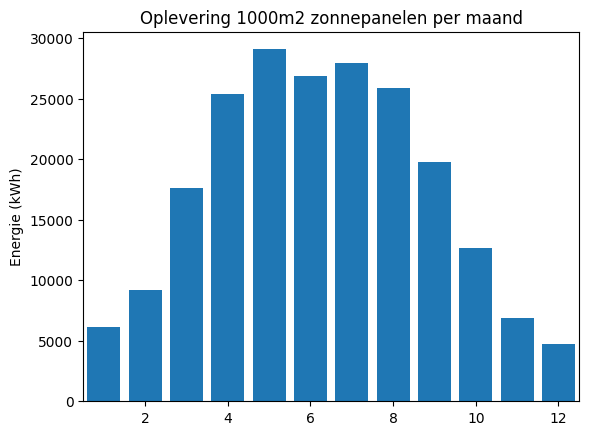

In [91]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

ax1.plot(months, roi)
ax1.bar(months, money)

ax1.set_title('Return on investment 1000m2 zonnepanelen');
ax1.set_ylabel('Geld €')
ax1.set_xlabel('Tijd (maanden)')
ax1.set_xlim(0, 144);

ax2.bar(months, energies)
ax2.set_title('Oplevering 1000m2 zonnepanelen per maand');
ax2.set_ylabel('Energie (kWh)')
ax2.set_xlim(0.5, 12.5);

